In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math as math
from IPython.display import clear_output
from numpy import linalg as la
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
#I made startYear in a different notebook. it takes 12 hours to run so no way I'm editing that again anyway
startYear = pd.read_csv('StartYears.csv');
ind = pd.read_csv("WDIEXCEL.csv")
IndicatorNames = ind['Indicator Name'].unique()
CountryNames = ind['Country Name'].unique()
startYear = startYear.rename(index=str, columns={"Unnamed: 0": 'Country Names'})

In [6]:
#remove indicators that do not have enough data 
miss_tol = 20; #missing country tolerance
late = 2005; #if we only have data later than this, it doesn't count
IndicatorsToRemove = [];
for j in range(1, len(IndicatorNames)): #each indicator (1 is country names)
    missing = 0;
    for i in range(47, len(CountryNames)):  #each country (up untill 47 is regions)
        #if(IndicatorNames[j]=='Land area (sq. km)'):
        #    print(startYear.iloc[i,j+1])
        if(pd.isna(startYear.iloc[i,j+1]) or pd.to_numeric(startYear.iloc[i,j+1])>late): 
            missing+=1;
            if(missing>miss_tol):
                IndicatorsToRemove.append(IndicatorNames[j]);
                #print(IndicatorNames[j], pd.to_numeric(startYear.iloc[i,j]))
                missing = 0;
                break;
            clear_output();
            print(j)
            

1590


In [7]:
#creates a new dataframe 'interpolated' that only has indicators with sufficient data and interpolated
remainingIndicators = [];
for j in range(0, len(IndicatorNames)):
    if (IndicatorNames[j] not in IndicatorsToRemove):
        remainingIndicators.append(IndicatorNames[j]);
filtered = ind[ind['Indicator Name'].isin(remainingIndicators) & ind['Country Name'].isin(CountryNames[47:])]
temp = filtered.iloc[0:, 4:].interpolate(axis=1)
temp2 = filtered.iloc[:, 0:4]
interpolated = pd.concat((temp2, temp), axis=1, join='inner')

In [5]:
#creates a new dataframe 'forpca' that uses the last year of interpolated and fills or NaNs with the mean of the indicator
IndicatorNames2 = interpolated['Indicator Name'].unique()
CountryNames2 = interpolated['Country Name'].unique()
forPCA = pd.DataFrame(index = CountryNames2, columns = IndicatorNames2);
for i in range(0, len(CountryNames2)):
    for j in range(0, len(IndicatorNames2)):
        s = interpolated[(interpolated['Country Name'] == CountryNames2[i]) & 
                          (interpolated['Indicator Name'] == IndicatorNames2[j])]
        
        clear_output()
        print(len(CountryNames2)-1-i);
        forPCA.iloc[i,j] = s.iloc[0, 61];
forPCA = forPCA.fillna(forPCA.mean())

0


In [7]:
#^^^^^^^^^^^^^THIS STUFF TAKES A WHILE TO RUN^^^^^^^^^^^^^#
#I'm saving the dataframes that matter into csv files.....#
#If no changes are being made to the preprocessing and....#
#To the PCA data, run the first 2 boxes and skip to the...#
#box below this...........................................#
interpolated.to_csv('Final_Interpolated.csv')
forPCA.to_csv('Final_forPCA.csv')

In [3]:
#!!!!!!!!!!!>>>>>LOOK AT ME<<<<!!!!!!!!!!!!!!!!!!!#
#Skip this if you're running the code for the first time
#Or if changes were made to the preprocessing
interpolated = pd.read_csv('Final_Interpolated.csv')
forPCA = pd.read_csv('Final_forPCA.csv')
interpolated = interpolated.iloc[:, 1:]
forPCA = forPCA.rename(index=str, columns={'Unnamed: 0' : 'Country Names'})
forPCA.index = forPCA['Country Names']
forPCA = forPCA.iloc[:, 1:]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

In [4]:
#demean and scale var
x = forPCA
means = x.mean(axis=0)
std = x.std(axis=0, ddof=0)
for i in range(0, len(x)): #216
    for j in range(0, len(x.columns)): #156
        x.values[i][j] -= means[j];
        x.values[i][j] /= std[j];
    

In [5]:
#Calculate the covariance matrix and the eigensystem (also sort)
X = x.values
M = np.matmul(X.transpose(), X)
val,vec = la.eig(M)
idx = val.argsort()[::-1]   
eigenValues = val[idx]
eigenVectors = vec[:,idx]

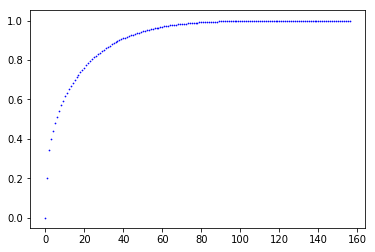

In [6]:
#Just used this for figuring out how many eigenvalues to take
#the first 35 eigenvalues account for 80% of variance 
xx = [];
yy = [];
s = 0;
for i in range(0, len(eigenValues)):
    s+=eigenValues[i]
sum2 = 0
for i in range(0, len(eigenValues)):
    #print(i, sum2/s)
    xx.append(i);
    yy.append(sum2/s);
    sum2+=eigenValues[i];
import matplotlib.pyplot as plt
plt.scatter(xx, yy, s=0.5, c="b")

In [7]:
#Calculate 'weight' of each component based on how alligned it is with the first 35 PCA components
for i in range(0, 157):
    for j in range(0,157):
        vec[i][j] = np.abs(vec[i][j]) * val[i]
ind_weight = [];
for j in range(0, 157):
    sum = 0;
    for i in range(0, 50):
        sum+=vec[i][j];
    ind_weight.append(sum)

In [8]:
#sort based on weights
weights = ind_weight
indics = forPCA.columns
indexes = np.array(weights).argsort()[::-1]
sorted_weights = np.array(weights)[indexes]
sorted_indics = np.array(indics)[indexes]

In [9]:
#Write a csv file with indicators sorted based on 'importance'
mustChoose = pd.DataFrame(index = range(0, len(ind_weight)),columns = np.array(['weight', 'indicator']))
descriptions = pd.read_csv('descriptions.csv')
for i in range(0, len(sorted_weights)):
    mustChoose.iloc[i, 0] = sorted_weights[i];
    mustChoose.iloc[i, 1] = sorted_indics[i];
    temp = descriptions[descriptions['Indicator Name'] == sorted_indics[i]];
mustChoose.to_csv('choose.csv')

8